# Principal Components Analysis (PCA)

## Exploring methods for picking the optimal number of Principal Components.

Methods tested: a) **Explained Variance Ratio**, b) **Kaiser's rule**, c) **Cross-Validation** using a classifier, d) **Parallel Analysis**.

*Costas Andreopoulos \<c.andreopoulos@cern.ch\>*

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error

from IPython.display import display, HTML

**Generate a synthetic dataset and standardize the data using Z-score normalization**

In [45]:
random_state  =   35
n_samples     = 1000
n_features    =   12 # total number of features
n_informative =    5 # number of features that actually matter for predicting the class
n_redundant   =    3 # linear combinations of the informative ones
n_repeated    =    2 # exact duplicates
n_noise       = n_features - n_informative - n_redundant - n_repeated

feature_names = [f"x{i}" for i in range(1,n_features+1)] # set generic feature names

# Generate dataset
X, Y = make_classification(n_samples=n_samples, n_features=n_features, 
                           n_informative=n_informative, n_redundant=n_redundant, n_repeated=n_repeated,
                           random_state=random_state)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) 

**Convert to synthetic dataset to a Pandas DataFrame and print/visualize**

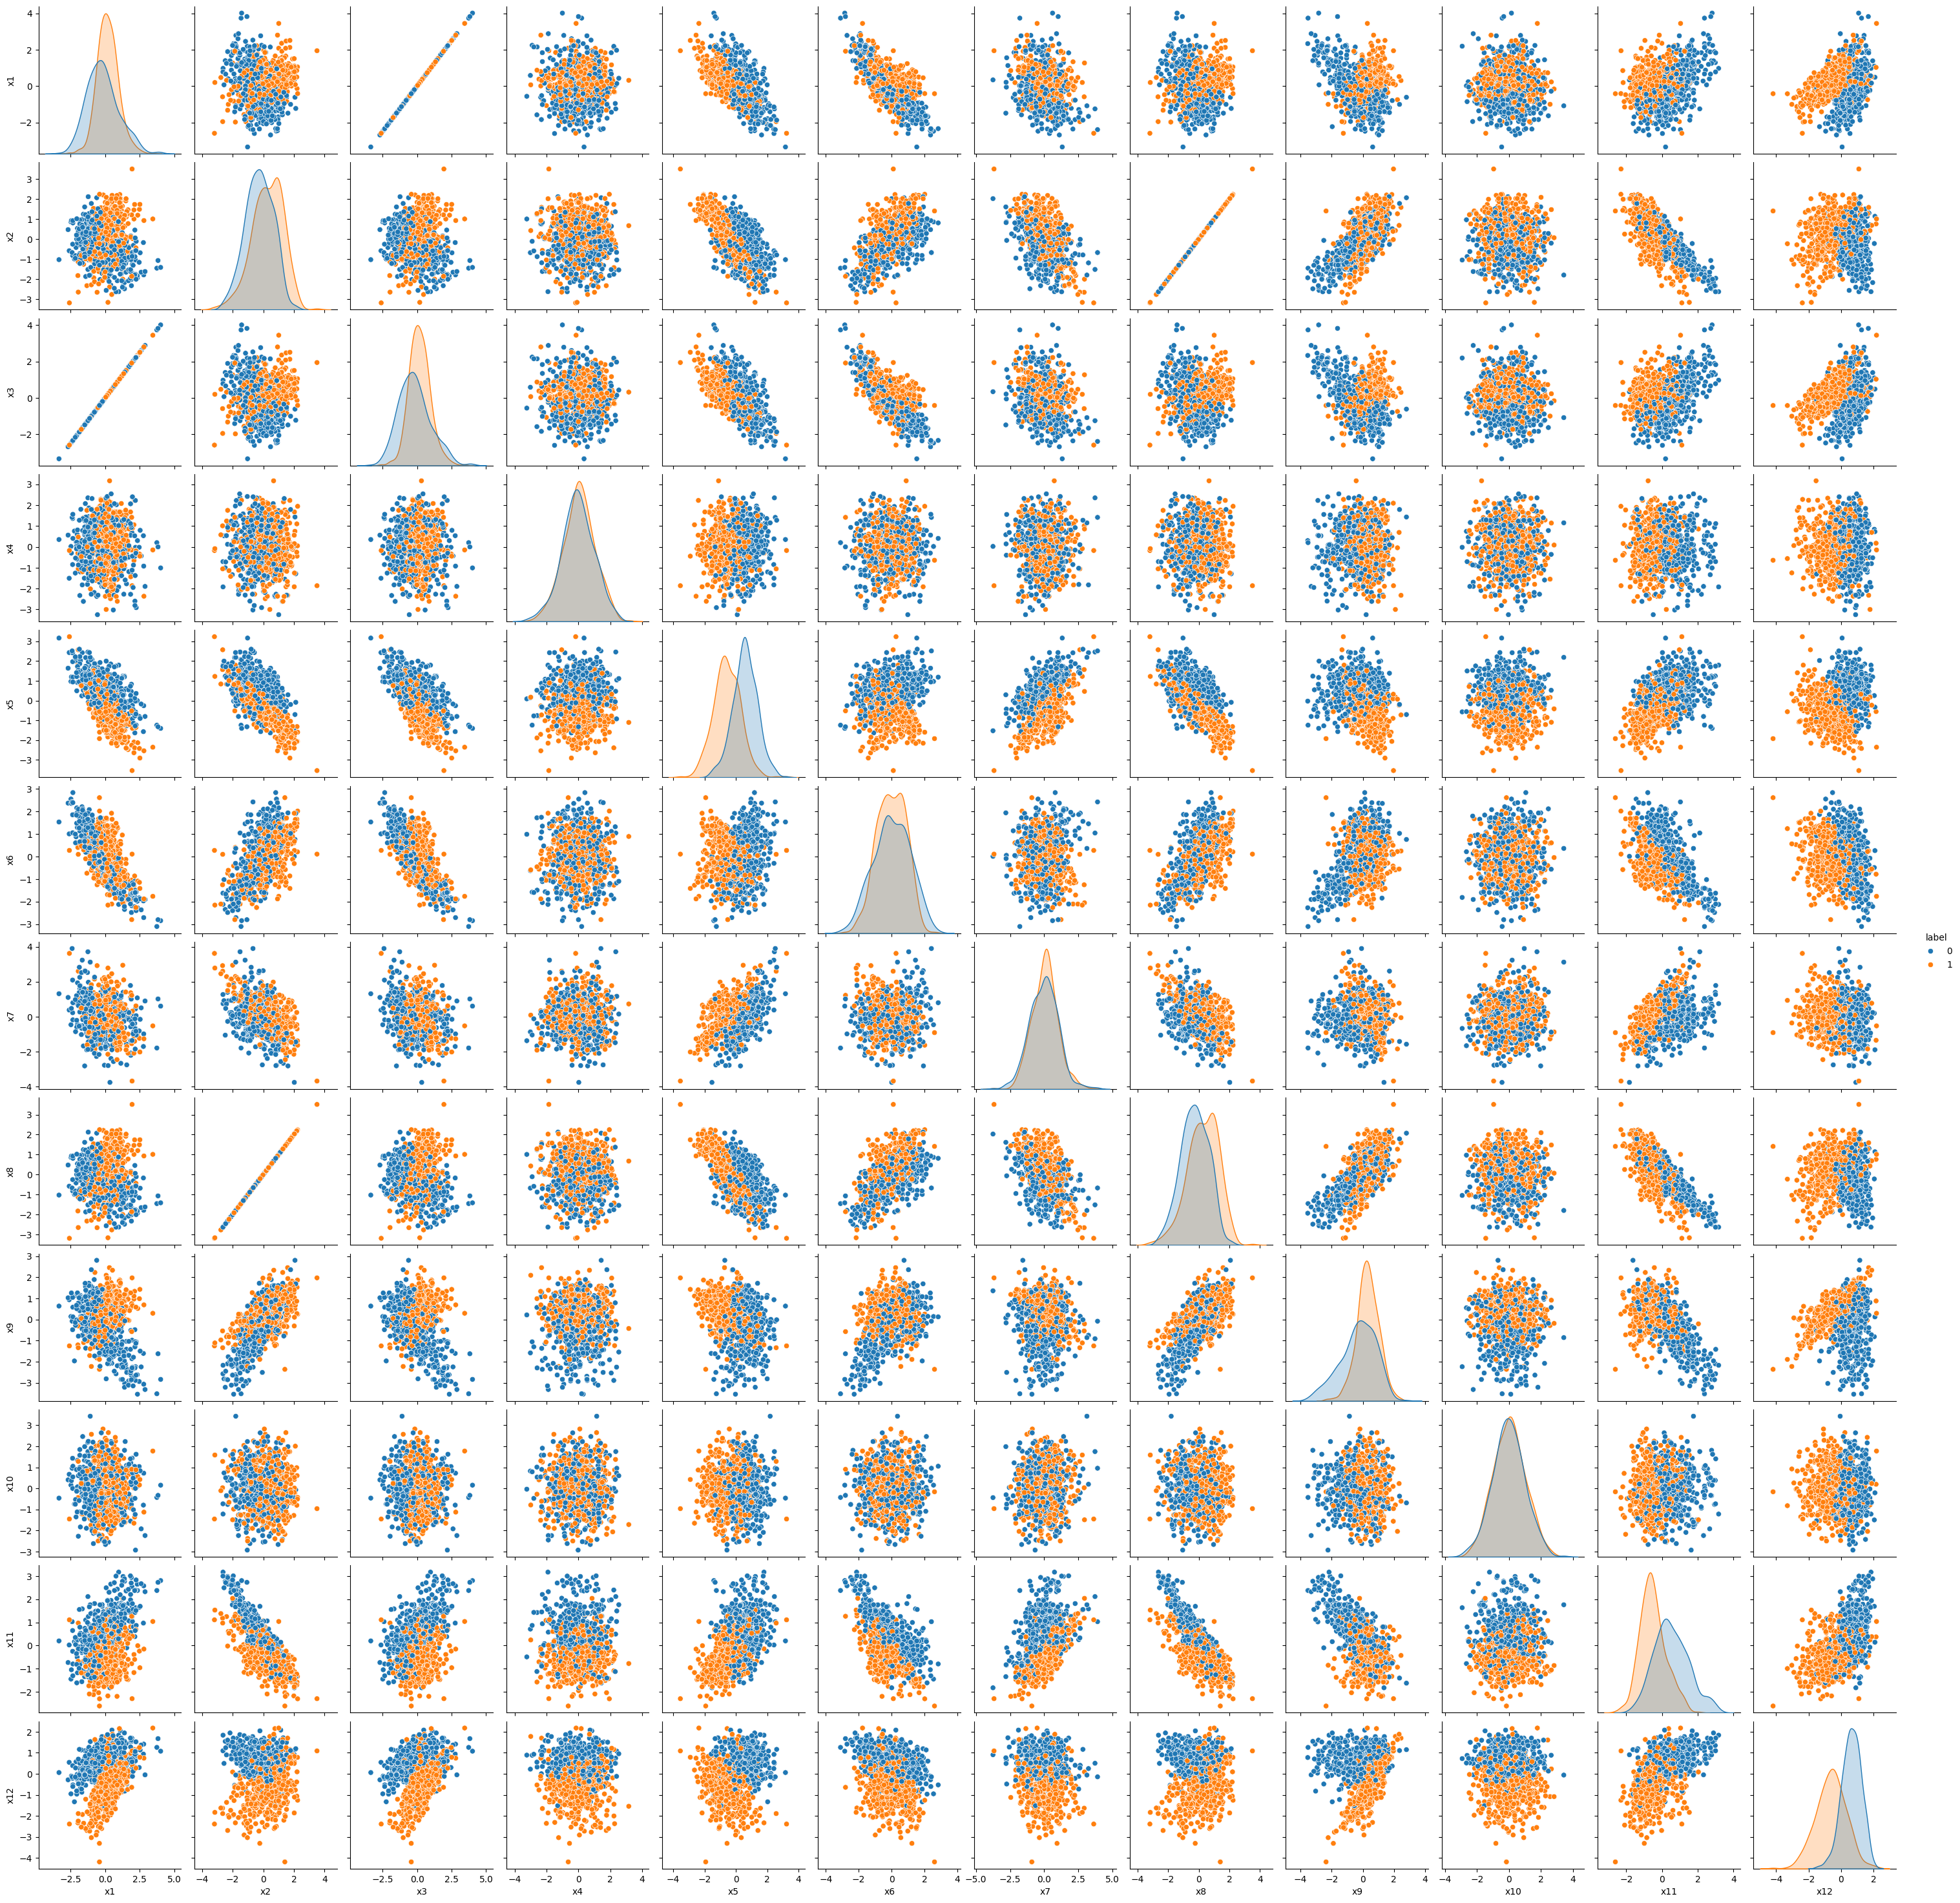

In [46]:
# Convert dataset to DataFrame 
df = pd.DataFrame(X_scaled, columns=feature_names)
df['label'] = Y  # Add target label names

# # Convert DataFrame to an interactive HTML table with scrollable output
# html = df.to_html(max_rows=20, max_cols=10)
# display(HTML('<style> .dataframe {max-height: 300px; overflow-y: scroll; overflow-x: scroll; display: block; } </style>'))
# display(HTML(df.to_html()))
# # display(df) # simpler option if the above doesn't work

# Visualize relationships between features in the dataset 
_ = sns.pairplot(df, hue="label")

## Picking the optimal number of Principal Components


### Method 1: Explained variance ratio

Plot the cumulative distribution of the explained variance ratio for each Principal Component and **look for the elbow point where adding more Principal Components contributes only a small increase in variance**. Typically, we keep enough components to explain at least 95% of the variance.

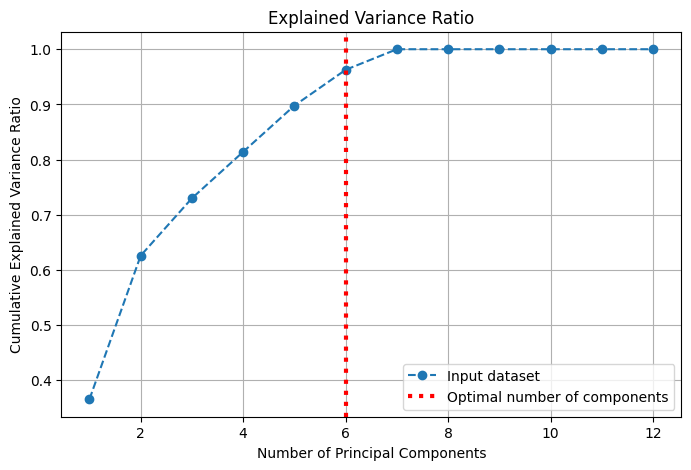

In [47]:
variance_ratio_threshold = 0.95

# Initially, apply PCA on the input dataset, using as many principal components as there are features in the dataset
pca = PCA(n_components=n_features)  
X_reduced = pca.fit_transform(X_scaled)

# Get the explained variance ratio for each component, and the cumulative distribution

# Plot the cumulative distribution of the explained variance ratio from the application of PCA on the input data.
variance_ratio_data = pca.explained_variance_ratio_
variance_ratio_data_cumulative = np.cumsum(variance_ratio_data)
# print(f"Explained variance ratio for the {pca.n_components_} PCA components:\n {variance_ratio_data}")

# Determine the optimal number of components from this method
n_components_optimal_method1 = 1 + np.sum(variance_ratio_data_cumulative < variance_ratio_threshold)

# Make a `scree plot' and look for an elbow point. 
# Mark the optimal number of components determined above,
plt.figure(figsize=(8,5))
plt.plot(range(1, n_features+1), variance_ratio_data_cumulative, marker='o', linestyle='--', label="Input dataset")
plt.axvline(n_components_optimal_method1, color='red', linestyle='dotted', linewidth=3, label="Optimal number of components")
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio')
plt.legend()
plt.grid(True)
plt.show()

### Method 2: Kaiser's rule

Keep all the components with PCA eigenvalues (explained variance) greater than 1. Note that if the original dataset was standardised (using Z-score normalization) then all components in the original dataset have a variance of 1.

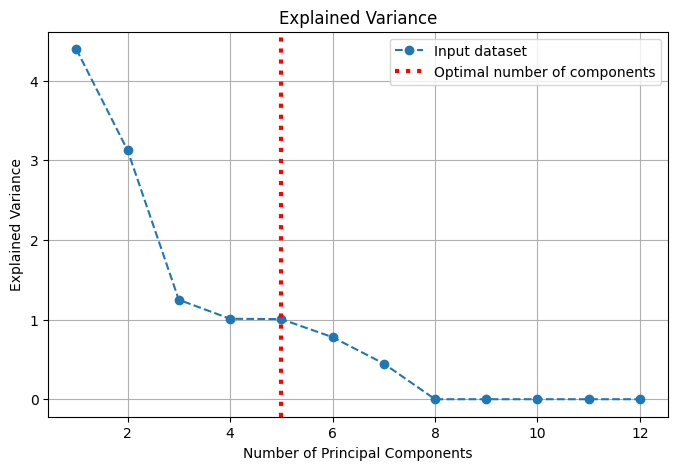

In [48]:
variance_threshold = 1.0

# Get the PCA eigenvalues for the input data (explained variance along each Principal Component) 
# and plot them as a function of the Principal Component
variance_data = pca.explained_variance_
# print(f"Explained variance ratio for the {pca.n_components_} PCA components:\n {variance_data}")

# Determine the optimal number of components from this method
n_components_optimal_method2 = np.sum(variance_data > variance_threshold)

plt.figure(figsize=(8,5))
plt.plot(range(1, n_features+1), variance_data, marker='o', linestyle='--', label="Input dataset")
plt.axvline(n_components_optimal_method2, color='red', linestyle='dotted', linewidth=3, label="Optimal number of components")
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

### Method 3: Cross-Validation

**Use a classifier and check the accuracy for different reductions of the initial dataset** obtained by running PCA with different number of components. Below, I will use a Boosted Decision Tree (BDT) as a classifier and demand an accuracy above 90%.

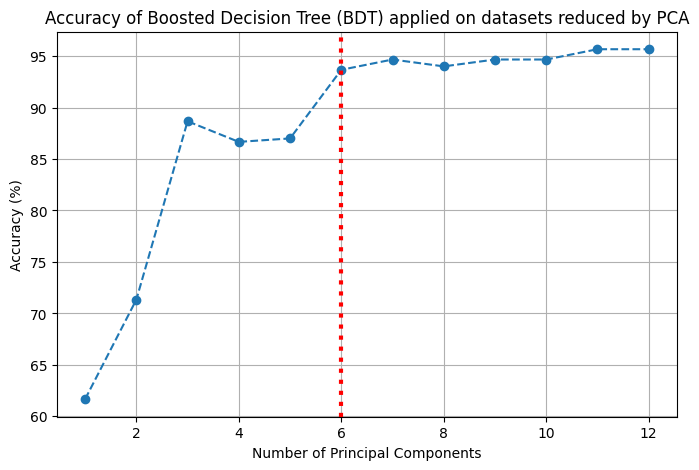

In [49]:
accuracy_threshold = 90 # %

# Run PCA with a varied number of components. Using each PCA run, reduce the dimensionality of the
# input dataset, split the reduced dataset into a training and test sample, train a BDT and evaluate its accuracy.
accuracy_scores = []
for n_components in range (1,1+n_features):
    # Run PCA and reduce the dimensionality of the input dataset
    pca_varied_n_components = PCA(n_components=n_components)  
    X_reduced = pca_varied_n_components.fit_transform(X_scaled)
    # Split the data in a training and a test sample
    X_train, X_test, Y_train, Y_test = train_test_split(X_reduced, Y, test_size=0.3, random_state=10)
    gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
    gb.fit(X_train, Y_train)
    # Make predictions for the test set
    Y_predicted = gb.predict(X_test)
    # Evaluate performance
    acc = 100*accuracy_score(Y_test, Y_predicted)
    # print(f"Gradient Boosting Accuracy on dataset reduced using {n_components} principal components: {acc:.2f}%")
    accuracy_scores.append(acc)

# Determine the optimal number of components from this method
accuracy_scores = np.array(accuracy_scores) # convert list to numpy array
indices = np.where(accuracy_scores > accuracy_threshold)[0]
if indices.size > 0:
    n_components_optimal_method3 = indices[0]+1
else:
    print(f"No accuracy values above {accuracy_threshold} found.")
    
# Plot
plt.figure(figsize=(8,5))
plt.plot(range(1, n_features+1), accuracy_scores, marker='o', linestyle='--', label="Input data")
plt.axvline(n_components_optimal_method3, color='red', linestyle='dotted', linewidth=3, label="Optimal number of components")
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of Boosted Decision Tree (BDT) applied on datasets reduced by PCA')
plt.grid(True)
plt.show()    

# Method 4: Parallel Analysis

**Compare the eigenvalues of real data with those from randomly generated datasets of the same size.**
Meaningful structure is likely to be contained in components with eigenvalues greater than those of random data.

Below, I will a) generate multiple random datasets, b) perform PCA on each random dataset, c) calculate the mean PCA eigenvalues, and d) compare with the eigenvalues obtained by running PCA on my original dataset.

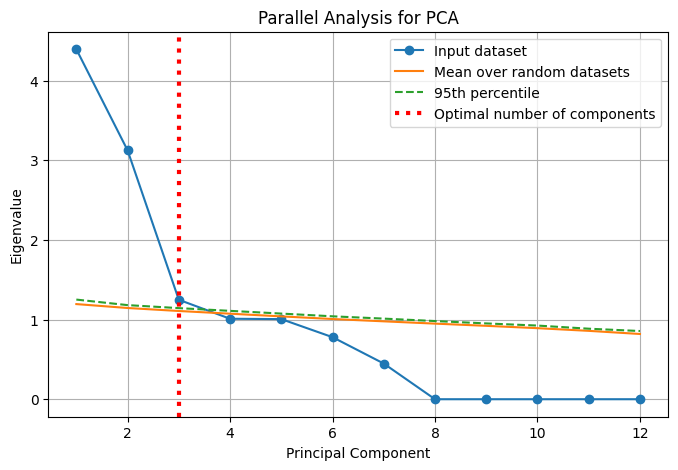

In [50]:
n_random_datasets = 200 # number of random datastes to generate
rng = np.random.default_rng(44) # specify seed to ensure reproducibility

# Initialize the PCA eigenvalues (explained variance) for all random datasets and all principal components.
variance_random = np.zeros((n_random_datasets,n_features)) 

# Generate the required number of random datasets, run PCA, and store the eigenvalues
for i in range(n_random_datasets):
    X_random = rng.normal(size=(n_samples, n_features))
    pca_random = PCA(n_components=n_features)  
    pca_random.fit(X_random)
    variance_random[i,:] = pca_random.explained_variance_

# Compute the mean eigenvalue for each component
mean_variance_random = np.mean(variance_random, axis=0) # axis=0 -> compute the mean column-wise

# Compute the 95th percentile of the eigenvalue for each component
percentile95_variance_random = np.percentile(variance_random, 95, axis=0)

# Determine the optimal number of components from this method
n_components_optimal_method4 = np.sum(variance_data > mean_variance_random)

# Plot results
plt.figure(figsize=(8,5))
plt.plot(range(1, n_features + 1), variance_data, marker='o', label="Input dataset")
plt.plot(range(1, n_features + 1), mean_variance_random, marker='', linestyle="solid", label="Mean over random datasets")
plt.plot(range(1, n_features + 1), percentile95_variance_random, marker='', linestyle="dashed", label="95th percentile")
plt.xlabel("Principal Component")
plt.ylabel("Eigenvalue")
plt.axvline(n_components_optimal_method4, color='red', linestyle='dotted', linewidth=3, label="Optimal number of components")
plt.legend()
plt.title("Parallel Analysis for PCA")
plt.grid(True)
plt.show()

**Decide the optimal number of components based on methods 1-4, run PCA once more**

In [51]:
n_components_optimal = 6
pca_optimal = PCA(n_components=n_components_optimal)  
X_reduced_optimal = pca_optimal.fit_transform(X_scaled)

**Visualize relationships between the components**

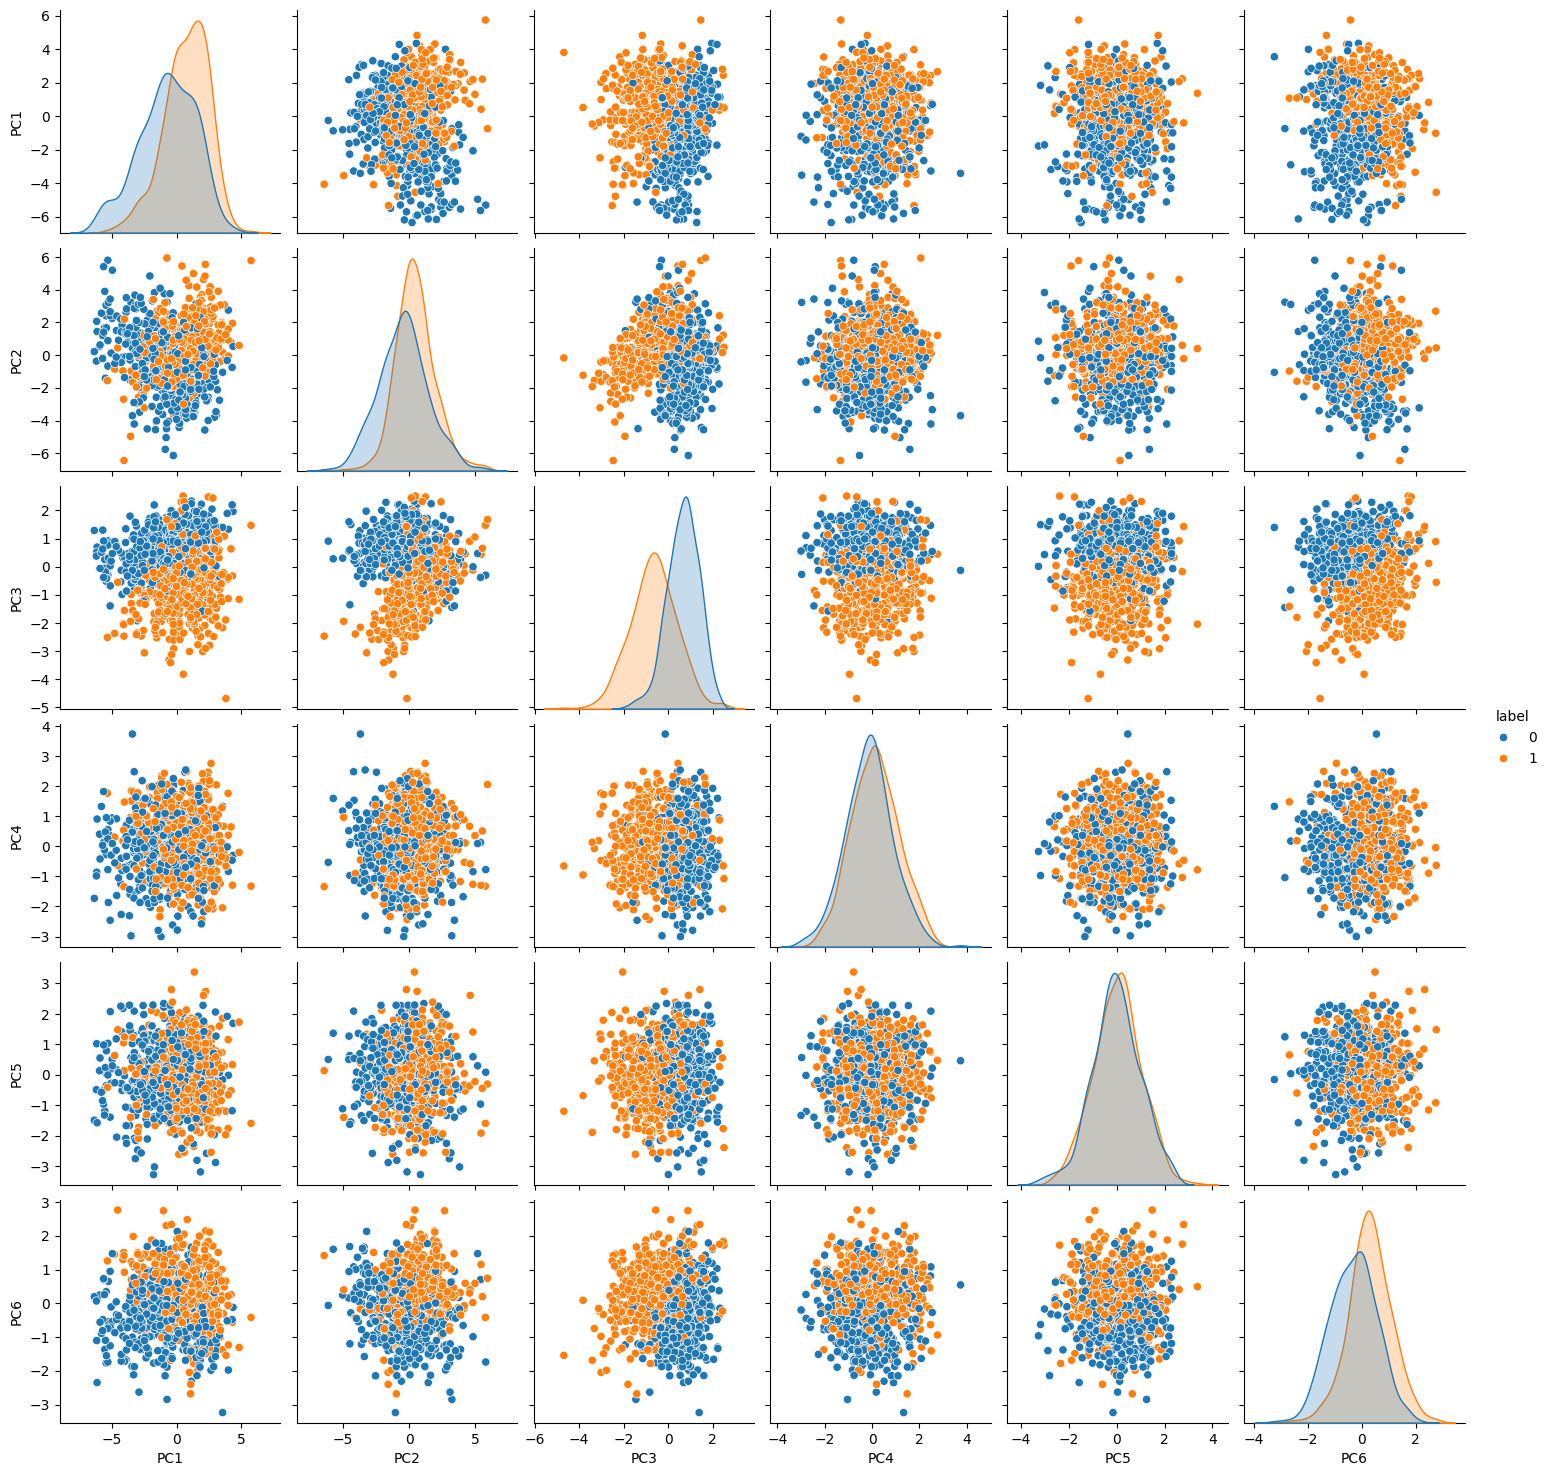

In [52]:
# Convert dataset to DataFrame 
pc_names = [f"PC{i}" for i in range(1,n_components_optimal+1)] # set generic names

df_reduced_optimal = pd.DataFrame(X_reduced_optimal, columns=pc_names)
df_reduced_optimal['label'] = Y  # Add target label names

# Visualize relationships between features in the dataset 
_ = sns.pairplot(df_reduced_optimal, hue="label")

**Calculate and print/draw various metrics**

In [53]:
# Reconstruct the original data by performing the inverse transform on the reduced data
X_reconstructed = pca_optimal.inverse_transform(X_reduced_optimal)  

# Compute reconstruction error
reconstruction_error = mean_squared_error(X_scaled, X_reconstructed)
print(f"Reconstruction Error: {reconstruction_error}")

Reconstruction Error: 0.03727465909840267


In [54]:
# Explained variance ratio
print(f"Cumulative Explained Variance Ratio:\n {np.cumsum(pca_optimal.explained_variance_ratio_)}")

Cumulative Explained Variance Ratio:
 [0.36586597 0.6260524  0.73000796 0.81412556 0.8978676  0.96272534]


In [55]:
# Run k-Means clustering on reduced data 
kmeans = KMeans(n_clusters=len(set(Y)), random_state=42)
Y_kmeans = kmeans.fit_predict(X_reduced_optimal)

# Evaluate clustering quality using the silhouette score
sl_score = silhouette_score(X_reduced_optimal, Y_kmeans)
print(f"Silhouette Score: {sl_score:.3f}")

Silhouette Score: 0.236
